# 单臂机器人 3D 重建 (基于 AirExo-2)

本 Notebook 使用 AirExo-2 代码库的原生函数,从 lowdim 数据和标定数据重建机器人的 3D 模型并进行渲染。

## 1. 导入依赖库

In [1]:
import os
import sys
import h5py
import json
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from PIL import Image
from IPython.display import display
import plotly.graph_objects as go

# # 添加 AirExo-2 到 Python 路径
# AIREXO_PATH = "/path/to/AirExo-2"  # 修改为你的 AirExo-2 路径
# sys.path.insert(0, AIREXO_PATH)

# 导入 AirExo-2 模块
from airexo.helpers.urdf_robot import forward_kinematic_single
from airexo.helpers.constants import ROBOT_PREDEFINED_TRANSFORMATION, O3D_RENDER_TRANSFORMATION
from airexo.helpers.renderer import RobotRenderer
from omegaconf import OmegaConf

print("✓ 所有库导入成功!")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✓ 所有库导入成功!


## 2. 配置路径

In [2]:
# ===== 数据路径配置 =====
SCENE_PATH = "/data/haoxiang/data/FLIPPING_v3/train/scene_0001"
LOWDIM_H5_PATH = os.path.join(SCENE_PATH, "lowdim/lowdim.h5")

# ===== 标定数据 =====
# 你可以直接在这里粘贴标定 JSON 数据
CALIB_DATA = {
    "is_global": True,
    "pose_in_link": [
        0.07783932332093665,
        0.2078814260418823,
        0.34723683952957585,
        0.2273133855008057,
        -0.6785647482083789,
        0.6637673415778982,
        -0.21746591345696367
    ],
    "error": 0.0024148397685646483,
    "parent_link_name": "world",
    "cam_serial": "104122060902",
    "intrinsics": [
        [915.384521484375, 0.0, 633.3715209960938],
        [0.0, 914.9421997070312, 354.1505432128906],
        [0.0, 0.0, 1.0]
    ]
}

# ===== URDF 配置 =====
# 使用 AirExo-2 仓库中的 URDF 文件
# URDF_FILE = os.path.join(AIREXO_PATH, "airexo/urdf_models/robot/left_robot_inhand.urdf")
URDF_FILE = "airexo/urdf_models/robot/right_robot_inhand.urdf"

# ===== 关节配置 =====
# 加载 AirExo-2 的关节配置文件
# JOINT_CFG_PATH = os.path.join(AIREXO_PATH, "airexo/configs/joint/left/robot.yaml")
JOINT_CFG_PATH = "airexo/configs/joint/right/robot.yaml"

print(f"场景路径: {SCENE_PATH}")
print(f"Lowdim 数据: {LOWDIM_H5_PATH}")
print(f"URDF 文件: {URDF_FILE}")
print(f"关节配置: {JOINT_CFG_PATH}")

场景路径: /data/haoxiang/data/FLIPPING_v3/train/scene_0001
Lowdim 数据: /data/haoxiang/data/FLIPPING_v3/train/scene_0001/lowdim/lowdim.h5
URDF 文件: airexo/urdf_models/robot/right_robot_inhand.urdf
关节配置: airexo/configs/joint/right/robot.yaml


## 3. 加载数据

In [3]:
class SingleRobotData:
    """单臂机器人数据加载器"""
    
    def __init__(self, lowdim_h5_path, calib_data, joint_cfg_path, urdf_file):
        self.lowdim_h5_path = lowdim_h5_path
        self.calib_data = calib_data
        self.urdf_file = urdf_file
        
        # 加载关节配置
        self.joint_cfgs = OmegaConf.load(joint_cfg_path)
        
        # 加载 lowdim 数据
        self._load_lowdim_data()
        
        # 处理标定数据
        self._process_calibration()
        
    def _load_lowdim_data(self):
        """加载 HDF5 lowdim 数据"""
        print(f"\n📂 加载 lowdim 数据: {self.lowdim_h5_path}")
        
        with h5py.File(self.lowdim_h5_path, 'r') as f:
            print(f"\n数据集结构:")
            for key in f.keys():
                print(f"  - {key}: shape={f[key].shape}, dtype={f[key].dtype}")
            
            # 读取关节位置 (弧度)
            self.joint_positions = f['joint_position_rad_062046'][:]  # (N, 7)
            
            # 读取末端执行器状态 (夹爪)
            self.ee_states = f['ee_state_062046'][:]  # (N, 1)
            
            # 读取时间戳
            self.timestamps = f['timestamp'][:]  # (N,)
            
            # 读取 TCP 位姿 (用于验证)
            if 'tcp_pose_062046' in f:
                self.tcp_poses = f['tcp_pose_062046'][:]  # (N, 7)
        
        print(f"\n✓ 加载了 {len(self.timestamps)} 帧数据")
        print(f"  - 关节位置: {self.joint_positions.shape}")
        print(f"  - 夹爪状态: {self.ee_states.shape}")
        
    # def _process_calibration(self):
    #     """处理标定数据"""
    #     print(f"\n🎯 处理标定数据...")
        
    #     # 提取相机内参
    #     self.intrinsic = np.array(self.calib_data['intrinsics'], dtype=np.float32)
    #     print(f"相机内参矩阵:\n{self.intrinsic}")
        
    #     # 提取相机位姿 (world → camera)
    #     pose_in_link = self.calib_data['pose_in_link']
    #     position = np.array(pose_in_link[:3])
    #     quaternion = np.array(pose_in_link[3:])  # [qx, qy, qz, qw]
        
    #     # 构建 world → camera 变换矩阵
    #     rotation = Rotation.from_quat(quaternion).as_matrix()
    #     world_to_cam = np.eye(4, dtype=np.float32)
    #     world_to_cam[:3, :3] = rotation
    #     world_to_cam[:3, 3] = position
        
    #     # 我们需要 camera → robot_base 变换
    #     self.cam_to_base = np.linalg.inv(world_to_cam).astype(np.float32)
        
    #     print(f"相机位置 (world): {position}")
    #     print(f"cam_to_base 变换矩阵:\n{self.cam_to_base}")

    def _process_calibration(self):
        """处理标定数据"""
        print(f"\n🎯 处理标定数据...")
        
        # 提取相机内参
        self.intrinsic = np.array(self.calib_data['intrinsics'], dtype=np.float32)
        
        # 提取相机位姿 (Pose of Camera in World)
        pose_in_link = self.calib_data['pose_in_link']
        position = np.array(pose_in_link[:3])
        quaternion = np.array(pose_in_link[3:])  # [x, y, z, w]
        
        # 1. 构建变换矩阵
        # 该矩阵直接代表: Camera坐标系 -> World(Base)坐标系
        rotation = Rotation.from_quat(quaternion).as_matrix()
        
        # 定义 cam_to_base (即 T_base_camera)
        # 物理含义：将点从相机坐标系转换到基座坐标系
        cam_to_base_mat = np.eye(4, dtype=np.float32)
        cam_to_base_mat[:3, :3] = rotation
        cam_to_base_mat[:3, 3] = position
        
        self.cam_to_base = cam_to_base_mat
        
        # 如果你确实需要 world_to_cam (例如用于OpenGL视图变换)，那才需要求逆
        # self.world_to_cam = np.linalg.inv(self.cam_to_base)
        
        print(f"相机位置 (world): {position}")
        print(f"cam_to_base 变换矩阵 (无需求逆):\n{self.cam_to_base}")
        
    def get_joint_at_timestamp(self, timestamp_idx):
        """获取指定时间戳的关节数据"""
        # 7个机器人关节 + 1个夹爪
        joint_angles = self.joint_positions[timestamp_idx]  # (7,)
        ee_state = self.ee_states[timestamp_idx, 0]  # 夹爪宽度
        
        # 合并为完整的关节状态
        full_joint = np.concatenate([joint_angles, [ee_state]], axis=0)
        
        return full_joint


# 创建数据加载器
robot_data = SingleRobotData(
    lowdim_h5_path=LOWDIM_H5_PATH,
    calib_data=CALIB_DATA,
    joint_cfg_path=JOINT_CFG_PATH,
    urdf_file=URDF_FILE
)


📂 加载 lowdim 数据: /data/haoxiang/data/FLIPPING_v3/train/scene_0001/lowdim/lowdim.h5

数据集结构:
  - ee_command_062046: shape=(13036, 1), dtype=float32
  - ee_state_062046: shape=(13036, 1), dtype=float32
  - force_torque_062046: shape=(13036, 6), dtype=float32
  - joint_position_rad_062046: shape=(13036, 7), dtype=float32
  - joint_velocity_062046: shape=(13036, 7), dtype=float32
  - pedal_0: shape=(13036, 1), dtype=float32
  - tcp_pose_062046: shape=(13036, 7), dtype=float32
  - tcp_vel_062046: shape=(13036, 6), dtype=float32
  - timestamp: shape=(13036,), dtype=int64

✓ 加载了 13036 帧数据
  - 关节位置: (13036, 7)
  - 夹爪状态: (13036, 1)

🎯 处理标定数据...
相机位置 (world): [0.07783932 0.20788143 0.34723684]
cam_to_base 变换矩阵 (无需求逆):
[[-0.8020744  -0.01980016  0.5968958   0.07783932]
 [-0.5971872   0.01548308 -0.8019524   0.20788142]
 [ 0.006637   -0.99968404 -0.02424299  0.34723684]
 [ 0.          0.          0.          1.        ]]


## 4. 正向运动学重建

In [4]:
def reconstruct_robot_at_frame(robot_data, frame_idx):
    """
    在指定帧重建机器人 3D 模型
    
    参数:
        robot_data: 数据加载器对象
        frame_idx: 帧索引
        
    返回:
        transforms: link 变换字典
        visuals_map: 视觉模型映射
        meshes: 变换后的网格列表
    """
    print(f"\n🤖 重建帧 {frame_idx} (时间戳: {robot_data.timestamps[frame_idx]})")
    
    # 获取该帧的关节状态
    joint_state = robot_data.get_joint_at_timestamp(frame_idx)
    print(f"关节状态 (rad): {joint_state[:7]}")
    print(f"夹爪宽度: {joint_state[7]:.4f} m")
    
    # 使用 AirExo-2 的正向运动学函数
    print("\n执行正向运动学...")
    transforms, visuals_map = forward_kinematic_single(
        joint=joint_state,
        joint_cfgs=robot_data.joint_cfgs,
        is_rad=True,  # 数据已经是弧度
        urdf_file=robot_data.urdf_file,
        with_visuals_map=True
    )
    
    print(f"✓ 计算了 {len(transforms)} 个 link 的变换")
    
    # 加载并变换 3D 网格
    print("\n加载 3D 网格...")
    meshes = []
    urdf_dir = os.path.dirname(robot_data.urdf_file)
    
    for link_name, transform in transforms.items():
        visuals = visuals_map.get(link_name, [])
        
        for visual in visuals:
            if visual.geom_param is None:
                continue
            
            # 获取网格文件路径
            mesh_file = visual.geom_param
            if isinstance(mesh_file, (list, tuple)):
                mesh_file = mesh_file[0]
            
            mesh_path = os.path.join(urdf_dir, mesh_file)
            
            if not os.path.exists(mesh_path):
                print(f"⚠️  网格文件不存在: {mesh_path}")
                continue
            
            # 计算变换链: visual_offset → link → URDF_correction
            tf = ROBOT_PREDEFINED_TRANSFORMATION @ \
                 transform.matrix() @ \
                 visual.offset.matrix()
            
            # 加载网格
            mesh = o3d.io.read_triangle_mesh(mesh_path)
            mesh.transform(tf)
            mesh.compute_vertex_normals()
            mesh.paint_uniform_color([0.7, 0.7, 0.7])  # 灰色
            
            meshes.append({
                'link_name': link_name,
                'mesh_file': mesh_file,
                'mesh': mesh,
                'transform': tf
            })
            
            print(f"  ✓ {link_name}: {os.path.basename(mesh_file)}")
    
    print(f"\n✓ 成功加载 {len(meshes)} 个网格")
    
    return transforms, visuals_map, meshes


# 测试重建
FRAME_IDX = 0
transforms, visuals_map, meshes = reconstruct_robot_at_frame(robot_data, FRAME_IDX)


🤖 重建帧 0 (时间戳: 1767593840232)
关节状态 (rad): [ 0.6657125  -1.0406699  -1.9467313   2.145058    1.6500233   0.39253008
  1.2164255 ]
夹爪宽度: 0.0002 m

执行正向运动学...
✓ 计算了 18 个 link 的变换

加载 3D 网格...
  ✓ base_link: link0.obj
  ✓ link1: link1.obj
  ✓ link2: link2.obj
  ✓ link3: link3r.obj
  ✓ link4: link4r.obj
  ✓ link5: link5.obj
  ✓ link6: link6r.obj
  ✓ link7: link7_inhand_r.stl
  ✓ robotiq_2f85_base_link: robotiq_2f85_base_link.stl
  ✓ left_outer_knuckle: outer_knuckle.stl
  ✓ left_outer_finger: outer_finger.stl
  ✓ left_inner_knuckle: inner_knuckle.stl
  ✓ left_inner_finger: inner_finger.stl
  ✓ right_inner_knuckle: inner_knuckle.stl
  ✓ right_inner_finger: inner_finger.stl
  ✓ right_outer_knuckle: outer_knuckle.stl
  ✓ right_outer_finger: outer_finger.stl

✓ 成功加载 17 个网格


## 5. 3D 可视化

In [5]:
# ## 5. 3D 可视化 (Jupyter 内嵌版本)

# def visualize_robot_3d_jupyter(meshes, show_coordinate_frame=True, 
#                                  point_size=1.0, background_color=[1, 1, 1]):
#     """
#     在 Jupyter Notebook 中内嵌显示机器人 3D 模型
    
#     参数:
#         meshes: 网格列表
#         show_coordinate_frame: 是否显示坐标系
#         point_size: 点云大小
#         background_color: 背景颜色 [R, G, B]
#     """
    
#     print(f"\n👁️  生成 3D 可视化...")
    
#     # 创建 Plotly 图形
#     fig = go.Figure()
    
#     # 添加坐标系
#     if show_coordinate_frame:
#         axis_length = 0.2
        
#         # 应用 ROBOT_PREDEFINED_TRANSFORMATION
#         origin = ROBOT_PREDEFINED_TRANSFORMATION[:3, 3]
        
#         # X 轴 (红色)
#         x_axis = ROBOT_PREDEFINED_TRANSFORMATION[:3, 0] * axis_length + origin
#         fig.add_trace(go.Scatter3d(
#             x=[origin[0], x_axis[0]],
#             y=[origin[1], x_axis[1]],
#             z=[origin[2], x_axis[2]],
#             mode='lines',
#             line=dict(color='red', width=5),
#             name='X-axis',
#             showlegend=True
#         ))
        
#         # Y 轴 (绿色)
#         y_axis = ROBOT_PREDEFINED_TRANSFORMATION[:3, 1] * axis_length + origin
#         fig.add_trace(go.Scatter3d(
#             x=[origin[0], y_axis[0]],
#             y=[origin[1], y_axis[1]],
#             z=[origin[2], y_axis[2]],
#             mode='lines',
#             line=dict(color='green', width=5),
#             name='Y-axis',
#             showlegend=True
#         ))
        
#         # Z 轴 (蓝色)
#         z_axis = ROBOT_PREDEFINED_TRANSFORMATION[:3, 2] * axis_length + origin
#         fig.add_trace(go.Scatter3d(
#             x=[origin[0], z_axis[0]],
#             y=[origin[1], z_axis[1]],
#             z=[origin[2], z_axis[2]],
#             mode='lines',
#             line=dict(color='blue', width=5),
#             name='Z-axis',
#             showlegend=True
#         ))
    
#     # 添加所有网格
#     colors = ['lightgray', 'silver', 'darkgray', 'gray', 'dimgray']
    
#     for i, mesh_data in enumerate(meshes):
#         mesh = mesh_data['mesh']
#         vertices = np.asarray(mesh.vertices)
#         triangles = np.asarray(mesh.triangles)
        
#         # 创建网格对象
#         fig.add_trace(go.Mesh3d(
#             x=vertices[:, 0],
#             y=vertices[:, 1],
#             z=vertices[:, 2],
#             i=triangles[:, 0],
#             j=triangles[:, 1],
#             k=triangles[:, 2],
#             color=colors[i % len(colors)],
#             opacity=0.8,
#             name=mesh_data['link_name'],
#             showlegend=True,
#             flatshading=True,
#             lighting=dict(ambient=0.5, diffuse=0.8, specular=0.5),
#             lightposition=dict(x=1000, y=1000, z=1000)
#         ))
        
#         print(f"  ✓ 添加网格: {mesh_data['link_name']}")
    
#     # 设置布局
#     fig.update_layout(
#         title=f"Robot 3D Reconstruction - Frame {FRAME_IDX}",
#         scene=dict(
#             xaxis=dict(title='X', backgroundcolor="white", gridcolor="lightgray"),
#             yaxis=dict(title='Y', backgroundcolor="white", gridcolor="lightgray"),
#             zaxis=dict(title='Z', backgroundcolor="white", gridcolor="lightgray"),
#             aspectmode='data',
#             camera=dict(
#                 eye=dict(x=1.5, y=1.5, z=1.5),
#                 center=dict(x=0, y=0, z=0),
#                 up=dict(x=0, y=0, z=1)
#             )
#         ),
#         width=1200,
#         height=800,
#         showlegend=True
#     )
    
#     print(f"\n✓ 3D 模型已生成，包含 {len(meshes)} 个网格")
#     print("\n🎮 交互控制:")
#     print("  - 鼠标拖拽: 旋转视角")
#     print("  - 鼠标滚轮: 缩放")
#     print("  - 右键拖拽: 平移")
    
#     return fig


# # 可视化重建结果
# fig = visualize_robot_3d_jupyter(meshes, show_coordinate_frame=True)
# fig.show()

import k3d
# import numpy as np

def visualize_robot_3d_k3d(meshes, show_coordinate_frame=True):
    """
    使用 K3D 在 Jupyter 中实现丝滑的 3D 可视化
    """
    # 1. 创建 Plot 对象
    # grid_visible: 是否显示网格
    # camera_auto_fit: 自动调整相机视角以容纳所有物体
    plot = k3d.plot(grid_visible=True, 
                    grid=[ -1, -1, -1, 1, 1, 1], # 网格范围
                    background_color=0xffffff,   # 白色背景
                    menu_visibility=True)        # 显示右上角控制面板

    # 2. 添加坐标系 (X-红, Y-绿, Z-蓝)
    if show_coordinate_frame:
        axis_length = 0.2
        # 提取原始位置和姿态
        origin = ROBOT_PREDEFINED_TRANSFORMATION[:3, 3].astype(np.float32)
        rot = ROBOT_PREDEFINED_TRANSFORMATION[:3, :3].astype(np.float32)
        
        # 定义轴的终点
        x_end = origin + rot[:, 0] * axis_length
        y_end = origin + rot[:, 1] * axis_length
        z_end = origin + rot[:, 2] * axis_length

        # K3D 中画线段代表坐标轴
        plot += k3d.line(np.stack([origin, x_end]), color=0xff0000, width=0.01, name="X-axis")
        plot += k3d.line(np.stack([origin, y_end]), color=0x00ff00, width=0.01, name="Y-axis")
        plot += k3d.line(np.stack([origin, z_end]), color=0x0000ff, width=0.01, name="Z-axis")

    # 3. 添加机器人网格
    # K3D 颜色需要十六进制整数
    hex_colors = [0xcccccc, 0xaaaaaa, 0x888888, 0x666666, 0x444444]
    
    for i, mesh_data in enumerate(meshes):
        mesh = mesh_data['mesh']
        
        # 转换顶点和面片索引为 K3D 要求的格式 (float32 和 uint32)
        vertices = np.asarray(mesh.vertices).astype(np.float32)
        indices = np.asarray(mesh.triangles).astype(np.uint32)
        
        # 创建 K3D 网格对象
        k3d_mesh = k3d.mesh(vertices, indices, 
                            color=hex_colors[i % len(hex_colors)],
                            name=mesh_data['link_name'],
                            opacity=1.0,  # K3D 的渲染性能很好，建议用不透明
                            side='double') # 双面渲染，防止法线反转看不见
        
        plot += k3d_mesh
        print(f"  ✓ 添加网格: {mesh_data['link_name']}")

    # 4. 显示
    plot.display()
    
    # 打印操作说明
    print("\n🎮 K3D 操作指南:")
    print("  - 左键拖拽: 自由旋转 (Trackball 模式，无角度限制)")
    print("  - 右键拖拽: 平移 (Pan)")
    print("  - 滚轮: 缩放 (Zoom)")
    print("  - 右上角菜单: 可以手动调节每个 Link 的可见性和颜色")
    
    return plot

# 运行可视化
plot_instance = visualize_robot_3d_k3d(meshes)

  ✓ 添加网格: base_link
  ✓ 添加网格: link1
  ✓ 添加网格: link2
  ✓ 添加网格: link3
  ✓ 添加网格: link4
  ✓ 添加网格: link5
  ✓ 添加网格: link6
  ✓ 添加网格: link7
  ✓ 添加网格: robotiq_2f85_base_link
  ✓ 添加网格: left_outer_knuckle
  ✓ 添加网格: left_outer_finger
  ✓ 添加网格: left_inner_knuckle
  ✓ 添加网格: left_inner_finger
  ✓ 添加网格: right_inner_knuckle
  ✓ 添加网格: right_inner_finger
  ✓ 添加网格: right_outer_knuckle
  ✓ 添加网格: right_outer_finger


Output()


🎮 K3D 操作指南:
  - 左键拖拽: 自由旋转 (Trackball 模式，无角度限制)
  - 右键拖拽: 平移 (Pan)
  - 滚轮: 缩放 (Zoom)
  - 右上角菜单: 可以手动调节每个 Link 的可见性和颜色


## 6. 渲染 RGB 图像

In [8]:
def render_robot_image(robot_data, meshes, width=1280, height=720):
    """
    使用离屏渲染器渲染机器人图像
    
    参数:
        robot_data: 数据加载器
        meshes: 网格列表
        width, height: 渲染分辨率
        
    返回:
        rgb_image: RGB 图像
        depth_image: 深度图
    """
    print(f"\n🎨 渲染 {width}x{height} 图像...")
    
    # 创建 Open3D 离屏渲染器
    renderer = o3d.visualization.rendering.OffscreenRenderer(width, height)
    
    # 设置材质
    material = o3d.visualization.rendering.MaterialRecord()
    material.shader = "defaultLit"
    
    # 添加网格到场景 (应用相机变换)
    for i, mesh_data in enumerate(meshes):
        # 复制网格避免修改原始数据
        mesh = mesh_data['mesh']
        mesh_copy = o3d.geometry.TriangleMesh(mesh)
        
        # 应用相机变换链
        mesh_copy.transform(
            O3D_RENDER_TRANSFORMATION @ robot_data.cam_to_base
        )
        
        renderer.scene.add_geometry(f"mesh_{i}", mesh_copy, material)
    
    # 设置相机投影
    renderer.scene.camera.set_projection(
        robot_data.intrinsic,
        0.01,    # near_plane
        100.0,   # far_plane
        float(width),
        float(height)
    )
    
    # 渲染
    rgb_image = np.asarray(renderer.render_to_image(), dtype=np.uint8)
    depth_image = np.asarray(
        renderer.render_to_depth_image(z_in_view_space=True),
        dtype=np.float32
    )
    
    print(f"✓ 渲染完成: RGB {rgb_image.shape}, Depth {depth_image.shape}")
    
    return rgb_image, depth_image


# 渲染图像
rgb_image, depth_image = render_robot_image(robot_data, meshes)


🎨 渲染 1280x720 图像...
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x561eee0e9a10 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
✓ 渲染完成: RGB (720, 1280, 3), Depth (720, 1280)


## 7. 显示渲染结果

/tmp/ipykernel_3296610/3089741993.py:14: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3296610/3089741993.py:14: RuntimeWarning:

invalid value encountered in cast



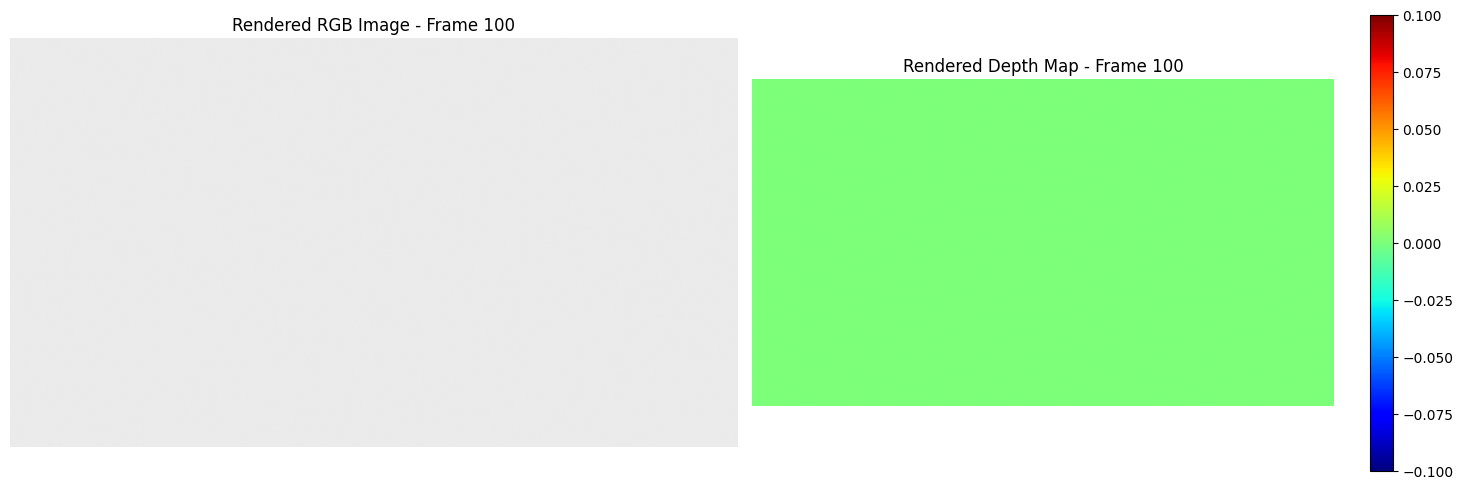


💾 保存图像...
✓ 已保存: robot_render_frame_100.png


In [9]:
# 显示 RGB 图像
plt.figure(figsize=(15, 5))

# RGB
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title(f"Rendered RGB Image - Frame {FRAME_IDX}")
plt.axis('off')

# Depth (归一化)
plt.subplot(1, 2, 2)
depth_vis = depth_image.copy()
depth_vis[depth_vis == np.inf] = 0
depth_vis = (depth_vis / depth_vis.max() * 255).astype(np.uint8)
plt.imshow(depth_vis, cmap='jet')
plt.title(f"Rendered Depth Map - Frame {FRAME_IDX}")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n💾 保存图像...")
Image.fromarray(rgb_image).save(f"robot_render_frame_{FRAME_IDX}.png")
print(f"✓ 已保存: robot_render_frame_{FRAME_IDX}.png")

## 8. 使用 RobotRenderer 类 (高级用法)

In [ ]:
# 使用 AirExo-2 的 RobotRenderer 类进行渲染
# 注意:这需要双臂配置,但我们可以适配为单臂

print("\n🎬 使用 RobotRenderer 类渲染...")

# 创建一个虚拟的右臂配置 (全零)
class DummyJointConfig:
    def __init__(self):
        self.num_joints = 8
        self.num_robot_joints = 7

renderer = RobotRenderer(
    left_joint_cfgs=robot_data.joint_cfgs,
    right_joint_cfgs=DummyJointConfig(),  # 虚拟右臂
    cam_to_base=robot_data.cam_to_base,
    intrinsic=robot_data.intrinsic,
    width=1280,
    height=720,
    near_plane=0.01,
    far_plane=100.0,
    urdf_file=os.path.join(AIREXO_PATH, "airexo/urdf_models/robot/robot.urdf")
)

# 更新关节状态
left_joint = robot_data.get_joint_at_timestamp(FRAME_IDX)
right_joint = np.zeros(8)  # 虚拟右臂

renderer.update_joints(left_joint, right_joint)

# 渲染
rendered_image = renderer.render_image()
rendered_depth = renderer.render_depth()

# 显示
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(rendered_image)
plt.title("RobotRenderer - RGB")
plt.axis('off')

plt.subplot(1, 2, 2)
depth_vis = (rendered_depth / rendered_depth.max() * 255).astype(np.uint8)
plt.imshow(depth_vis, cmap='jet')
plt.title("RobotRenderer - Depth")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ RobotRenderer 渲染完成!")

## 9. 批量处理多帧

In [ ]:
def batch_render_frames(robot_data, frame_indices, output_dir="./batch_output"):
    """
    批量渲染多帧
    
    参数:
        robot_data: 数据加载器
        frame_indices: 要渲染的帧索引列表
        output_dir: 输出目录
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"\n📹 批量渲染 {len(frame_indices)} 帧...")
    
    for i, frame_idx in enumerate(frame_indices):
        print(f"\n[{i+1}/{len(frame_indices)}] 处理帧 {frame_idx}")
        
        # 重建
        _, _, meshes = reconstruct_robot_at_frame(robot_data, frame_idx)
        
        # 渲染
        rgb, depth = render_robot_image(robot_data, meshes)
        
        # 保存
        output_path = os.path.join(output_dir, f"frame_{frame_idx:06d}.png")
        Image.fromarray(rgb).save(output_path)
        print(f"  ✓ 已保存: {output_path}")
    
    print(f"\n✓ 批量渲染完成! 输出目录: {output_dir}")


# 示例: 渲染第 0, 100, 200, 300, 400 帧
batch_render_frames(
    robot_data,
    frame_indices=[0, 100, 200, 300, 400],
    output_dir="./reconstruction_output"
)

## 10. 导出完整 3D 模型

In [ ]:
def export_3d_model(meshes, output_path="robot_model.ply"):
    """
    导出合并后的 3D 模型
    
    参数:
        meshes: 网格列表
        output_path: 输出文件路径
    """
    print(f"\n💾 导出 3D 模型...")
    
    # 合并所有网格
    combined_mesh = o3d.geometry.TriangleMesh()
    for mesh_data in meshes:
        combined_mesh += mesh_data['mesh']
    
    # 重新计算法线
    combined_mesh.compute_vertex_normals()
    
    # 保存
    o3d.io.write_triangle_mesh(output_path, combined_mesh)
    
    print(f"✓ 3D 模型已保存: {output_path}")
    print(f"  - 顶点数: {len(combined_mesh.vertices)}")
    print(f"  - 三角形数: {len(combined_mesh.triangles)}")


# 导出第 100 帧的 3D 模型
export_3d_model(meshes, output_path=f"robot_frame_{FRAME_IDX}.ply")

## 总结

本 Notebook 展示了如何使用 AirExo-2 的原生函数从 lowdim 数据重建单臂机器人的 3D 模型:

1. ✅ **数据加载**: 从 HDF5 文件读取关节角度和标定数据
2. ✅ **正向运动学**: 使用 `forward_kinematic_single` 计算 link 变换
3. ✅ **3D 重建**: 加载 URDF 网格并应用变换
4. ✅ **可视化**: 使用 Open3D 进行交互式 3D 可视化
5. ✅ **渲染**: 使用离屏渲染器生成 RGB 和深度图
6. ✅ **批量处理**: 支持多帧批量渲染
7. ✅ **模型导出**: 导出 PLY 格式的 3D 模型

### 关键技术点

- **坐标系变换链**: `visual_offset → link_transform → ROBOT_PREDEFINED_TRANSFORMATION → cam_to_base → O3D_RENDER_TRANSFORMATION`
- **关节数据**: 7个机器人关节 (弧度) + 1个夹爪宽度
- **URDF 解析**: 使用 `kinpy` 库进行正向运动学
- **渲染管线**: Open3D 离屏渲染 + 相机内参投影

### 下一步

- 🎥 制作动画序列
- 🔄 与真实 RGB 图像叠加对比
- 📊 分析 TCP 位姿误差
- 🎮 集成到数据可视化工具